In [246]:
import sys
# sys.path
# sys.path[5] = "C:\\ProgramData\\Anaconda3\\envs\\geoplot\\Lib\\site-packages"

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import geopandas as gpd
from osgeo import gdal
import pandas as pd
import xarray as xr
import rioxarray
from easy_mpl import taylor_plot
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import copy
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
import rioxarray

from matplotlib.lines import Line2D
# import rasterio
#PlateCarree EqualEarth()
import warnings
import matplotlib.patches as patches
import seaborn as sb
import matplotlib.ticker as ticker

In [247]:
def draw_hist(ax, array, bins, ran, cmap):
    input_array = array.reshape(-1)

    N, bins, patches = ax.hist(input_array, bins=bins, range=ran, edgecolor='black', density=True, linewidth=0.2)
    
    # ax.axes.xaxis.set_ticks([])
    # ax.axes.yaxis.set_ticks([]) 
    
    # ax.set_xticks([0, 0.25, 0.5, 0.75, 1], ["100%", "population", "Equal", "Probability", "100%"], rotation=90, fontsize=4)
    ax.set_facecolor("none")
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    # ax.spines['left'].set_visible(False)
    ax.spines["bottom"].set_linewidth("0.5")
    ax.spines["left"].set_linewidth("0.5")
    ax.margins(0, 0)
    ax.tick_params("x",which="major",
               length=2,width = 0.2,
               colors = "0.25")

    
    
    ax.tick_params("y",which="major",
               length=2,width = 0.2,
               colors = "0.25")
    formatter = ticker.FormatStrFormatter("%1.2f")
    ax.yaxis.set_major_formatter(formatter)
    # formatter = ticker.FormatStrFormatter("%1.1f")
    # ax.yaxis.set_major_formatter(formatter)
    
    cm = plt.get_cmap(cmap)
    for i in range(len(patches)):
        color = cm(1.*i/len(patches))  
        patches[i].set_facecolor(color)
    ax.tick_params("x",which="major",
               length=1.34,width = 0.8,
               colors = "0.25", pad=-0.01, labelsize=4.5)
    ax.tick_params("y",which="major",
                   length=1.34,width = 0.8,
                   colors = "0.25", pad=-0.01, labelsize=4.5)

In [248]:
def get_geotiff_data(path):
    """
    get gdal raster data
    """
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    array = array[:75, :]
    
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    
    lat = np.arange(ycor+0.5*yres, ycor+0.5*yres + yres*ysize, yres)[:75]
    lon = np.arange(xcor+0.5*xres, xcor+0.5*xres + xres*xsize, xres)
    return lon, lat, array

In [249]:
def draw(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number, c_list=None, p_value=None):
    ax1.outline_patch.set_linewidth(0.3)
    #设置颜色属性
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # array = array.astype(np.float32)
    # array[array==255] = np.nan
    if c_list is not None:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), colors=c_list,levels=levels, norm=norm, shading='nearest', extend="both")
    else:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="both")
    # cbar = fig.colorbar(cs, orientation='horizontal', pad=0.02, shrink=1, fraction=0.03, aspect=50)

    if p_value is not None:
        # significance
        p = p_value.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(),levels=2, vmin=0, vmax=0.8,  
                                  hatches=[None, 'xxxxxxxxxxxxxxxxxxx'],colors="none",add_colorbar=False,
                                  zorder=100)

    ax1.coastlines(linewidth=0.2)
    ax1.set_title("")
    # a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    ax1.set_extent([-179.9999, 179.9999, -60, 90],ccrs.PlateCarree())
    ax1.text(
        0.0, 0.95, number,
        fontsize=8,
        fontweight="bold",
        transform = ax1.transAxes
    )

In [250]:
def draw_lat_plot(ax, lat, data, data2, data3):
    
    
    x = lat
    a = data.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#23436C", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#23436C", linewidth=0.8, alpha=0.7)

    a = data2.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#F9922C", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#F9922C", linewidth=0.8, alpha=0.7)

    a = data3.copy()

    zeros = np.zeros(x.shape)
    a = np.ma.masked_array(a,mask=(np.isnan(a)))

    
    mean_value = a.mean(axis=1)[::-1]
    std_value = a.std(axis=1)[::-1]
    ax.fill_betweenx(x, mean_value-0.5*std_value, mean_value+0.5*std_value, color="#FA4F3E", alpha=0.2, linewidth=0.1)
    ax.plot(mean_value, x, color="#FA4F3E", linewidth=0.8, alpha=0.7)
    ax.plot([0, 0], [-90, 90], linewidth=0.5, color="orange", linestyle="--")
    # ax.fill_betweenx(x, y2, color="#CFA256", linewidth=0)
    ax.margins(0, 0)
    # ax.set_xlim(0)
    # ax.plot([0, 0], [-90, 90], linewidth=0.5, color="orange", linestyle="--")
    ax.set_ylim(-60, 85)
    ax.set_xlim(-50, 50)
    # ax.set_axisbelow(False)
    # ax.set_xlabel("Probability", fontsize=6)
    ax.set_ylabel("Latitude", labelpad=-1, fontsize=6)
    ax.set_yticks(np.arange(-40, 80.01, 20))
    
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    
    ax.tick_params("x",which="major",
               length=1.34,width = 0.8,
               colors = "0.25", pad=-0.01, labelsize=5)
    ax.tick_params("y",which="major",
                   length=1.34,width = 0.8,
                   colors = "0.25", pad=-0.01, labelsize=5)
    ax.tick_params(which = "minor",
                   length = 1.34, width = 0.8,
                   labelsize=4,labelcolor = "0.25")
    # ax.set_xticks([0, 0.1])

In [251]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

clist4 = ["#8C510A", "#BF812D", "#DFC27D", "#F6E8C3", "#C7EAE5", "#80CDC1", "#35978F", "#01665E"]
BRBG_newcmap = LinearSegmentedColormap.from_list('chaos',clist4)

C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_9212\1070986621.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_9212\1070986621.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_9212\1070986621.py:2: DeprecationWarning: The

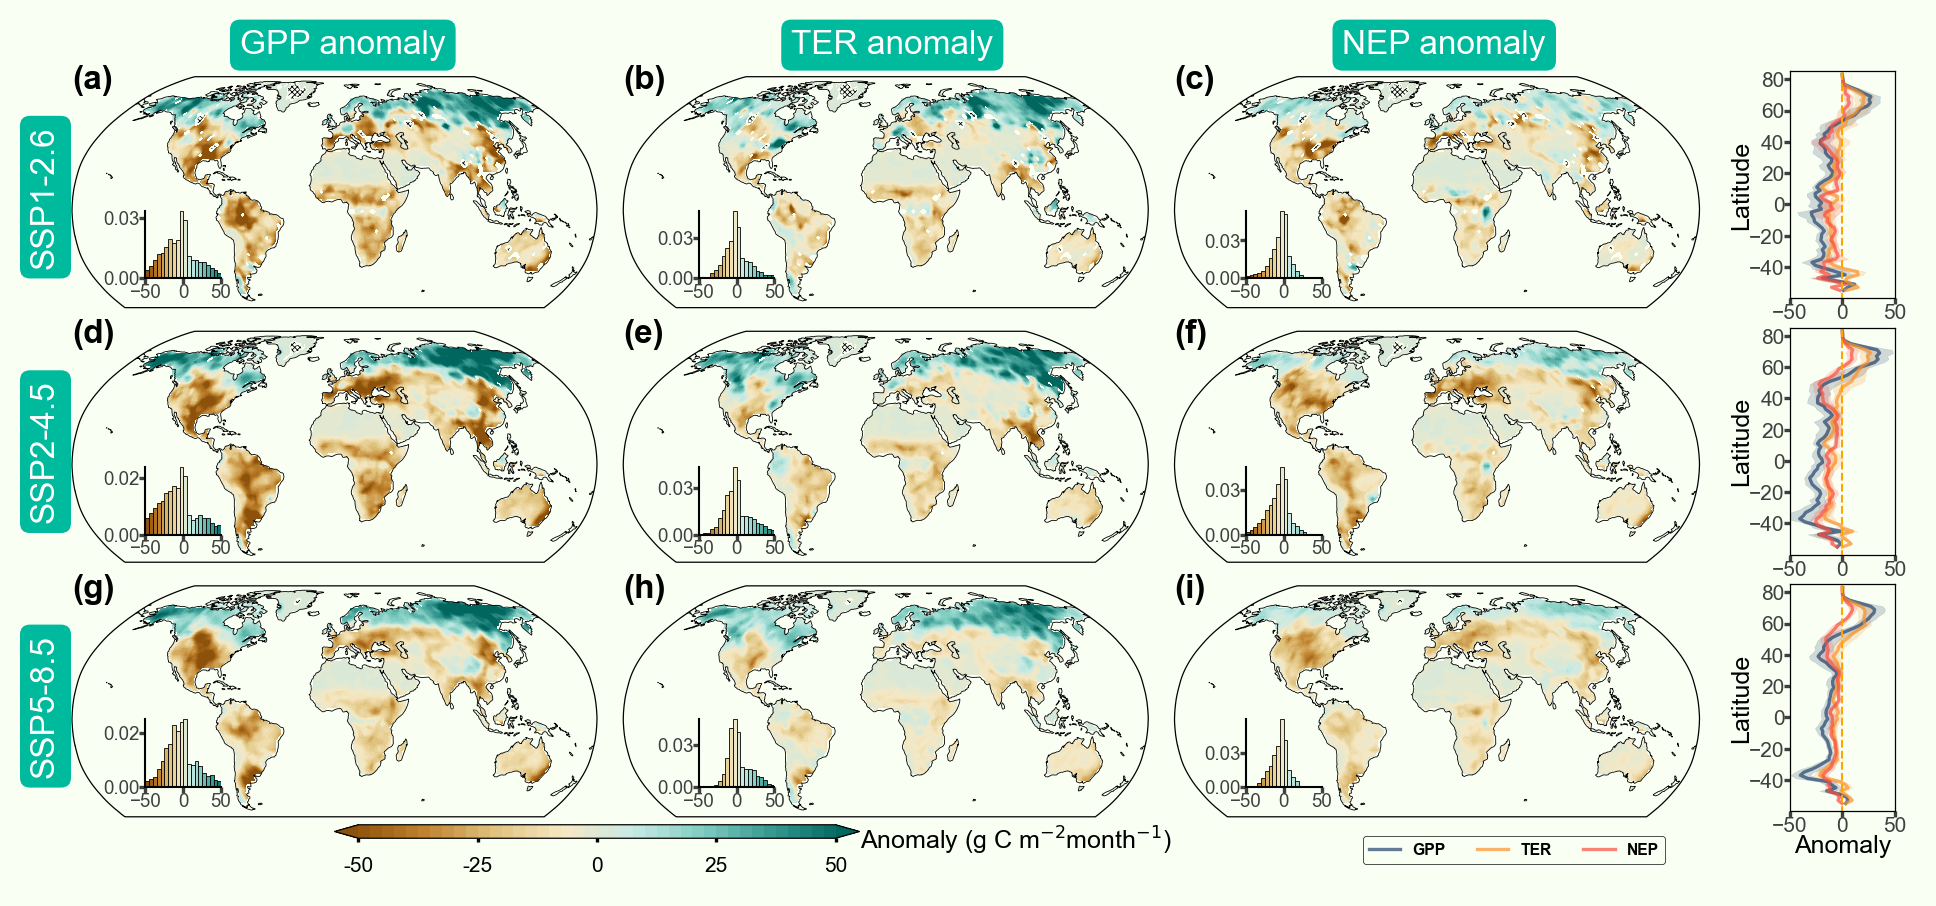

In [254]:
fig = plt.figure(figsize=(7,4.5), dpi=300)

mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
projection = ccrs.Robinson()

ax1 = fig.add_subplot(3, 3, 1,
                      projection=projection)
ref_arr = gdal.Open(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\output\warm_seasons_resampled\warm_season_mainland_2degree.tif").ReadAsArray()


lon, lat, array1 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\gpp_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\gpp_2sigma_anomalies_cdhw_2080_2099_ssp126_nodatamask.tif")
draw(ax1, '', lon, lat, array1, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(a)", p_value=p_value[0])

ax111 = plt.axes([0.16, 0.62, 0.036, 0.05])
draw_hist(ax111, array1, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax111, array1, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")



ax2 = fig.add_subplot(3, 3, 2,
                      projection=projection)

lon, lat, array2 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\ter_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\ter_2sigma_anomalies_cdhw_2080_2099_ssp126_nodatamask.tif")
# array2[array2!=0] = array2[array2!=0] + 0.0001
draw(ax2, '', lon, lat, array2, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(b)", p_value=p_value[0])


ax122 = plt.axes([0.4235, 0.62, 0.036, 0.05])
draw_hist(ax122, array2, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax122, array2, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")

ax3 = fig.add_subplot(3, 3, 3,
                      projection=projection)

lon, lat, array3 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\nep_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp126\nep_2sigma_anomalies_cdhw_2080_2099_ssp126_nodatamask.tif")
draw(ax3, '', lon, lat, array3, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(c)", p_value=p_value[0])

ax123 = plt.axes([0.684, 0.62, 0.036, 0.05])
draw_hist(ax123, array3, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax123, array3, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)

ax11 = plt.axes([0.943, 0.605, 0.05, 0.168])
draw_lat_plot(ax11, lat[::-1], array1, array2, array3)

ax4 = fig.add_subplot(3, 3, 4,
                      projection=projection)

lon, lat, array4 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\gpp_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\gpp_2sigma_anomalies_cdhw_2080_2099_ssp245_nodatamask.tif")
draw(ax4, '', lon, lat, array4, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(d)", p_value=p_value[0])

ax124 = plt.axes([0.16, 0.430, 0.036, 0.05])
draw_hist(ax124, array4, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax124, array4, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)

ax5 = fig.add_subplot(3, 3, 5,
                      projection=projection)

lon, lat, array5 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\ter_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\ter_2sigma_anomalies_cdhw_2080_2099_ssp245_nodatamask.tif")
draw(ax5, '', lon, lat, array5, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(e)", p_value=p_value[0])

ax125 = plt.axes([0.4235, 0.430, 0.036, 0.05])
draw_hist(ax125, array5, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax125, array5, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)

ax6 = fig.add_subplot(3, 3, 6,
                      projection=projection)

lon, lat, array6 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\nep_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp245\nep_2sigma_anomalies_cdhw_2080_2099_ssp245_nodatamask.tif")
draw(ax6, '', lon, lat, array6, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(f)", p_value=p_value[0])



ax126 = plt.axes([0.684, 0.430, 0.036, 0.05])
draw_hist(ax126, array6, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax126, array6, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)

ax22 = plt.axes([0.943, 0.415, 0.05, 0.168])
draw_lat_plot(ax22, lat[::-1], array4, array5, array6)

ax7 = fig.add_subplot(3, 3, 7,
                      projection=projection)

lon, lat, array7 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\gpp_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\gpp_2sigma_anomalies_cdhw_2080_2099_ssp585_nodatamask.tif")
draw(ax7, '', lon, lat, array7, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(g)", p_value=p_value[0])

ax127 = plt.axes([0.16, 0.243, 0.036, 0.05])
draw_hist(ax127, array7, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax127, array7, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)

ax8 = fig.add_subplot(3, 3, 8,
                      projection=projection)

lon, lat, array8 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\ter_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\ter_2sigma_anomalies_cdhw_2080_2099_ssp585_nodatamask.tif")
draw(ax8, '', lon, lat, array8, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(h)", p_value=p_value[0])

ax128 = plt.axes([0.4235, 0.243, 0.036, 0.05])
draw_hist(ax128, array8, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax128, array8, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)
fig.subplots_adjust(hspace=-0.3, wspace=0.05)

ax9 = fig.add_subplot(3, 3, 9,
                      projection=projection)

lon, lat, array9 = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\nep_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")
p_value = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled\ssp585\nep_2sigma_anomalies_cdhw_2080_2099_ssp585_nodatamask.tif")
draw(ax9, '', lon, lat, array9, vmin=-50, vmax=50, levels=np.arange(-50, 51, 2.5), cmap=BRBG_newcmap, number="(i)", p_value=p_value[0])

ax129 = plt.axes([0.684, 0.243, 0.036, 0.05])
draw_hist(ax129, array9, 20, (-50, 50), BRBG_newcmap)
# draw_proportion_chart(ax129, array9, np.arange(-50, 51, 2.5), np.arange(-50, 51, 2.5), BRBG_newcmap, colors=clist4)
ax33 = plt.axes([0.943, 0.225, 0.05, 0.168])
draw_lat_plot(ax33, lat[::-1], array7, array8, array9)


fig.subplots_adjust(hspace=-0.52, wspace=0.05)
fig.patch.set_facecolor('#F9FFF3')

ax11.set_facecolor('#F9FFF3')
ax22.set_facecolor('#F9FFF3')
ax33.set_facecolor('#F9FFF3')

#legend
ax33.set_xlabel("Anomaly", fontsize=6, labelpad=-0.3)

custom_lines = [Line2D([0], [0], color="#23436C", lw=0.8, alpha=0.7, label="GPP"),
                Line2D([0], [0], color="#F9922C", lw=0.8, alpha=0.7, label="TER"),
                Line2D([0], [0], color="#FA4F3E", lw=0.8, alpha=0.7, label="NEP")]
leg = ax8.legend(prop={"size": 3.75, "weight": "bold"}, fontsize=8, handles=custom_lines, bbox_to_anchor=(2, -0.05), edgecolor='k', ncol=3, facecolor="#F9FFF3")
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(0.2)

# adding some elements about scenarios and periods
props = dict(boxstyle='round', facecolor='#00BA9E', alpha=1, edgecolor="none")
ax1.text(
        0.32, 1.1, "GPP anomaly",
        color="white",
        fontsize=8,
        transform = ax1.transAxes,
        bbox=props
    
    )
ax2.text(
        0.32, 1.1, "TER anomaly",
    color="white",
        fontsize=8,
        transform = ax2.transAxes,
        bbox=props
    )
ax3.text(
        0.32, 1.1, "NEP anomaly",
    color="white",
        fontsize=8,
        transform = ax3.transAxes,
    bbox=props
    )
ax1.text(
        -0.08, 0.2, "SSP1-2.6",
    color="white",
        fontsize=8,
        rotation=90,
        transform = ax1.transAxes,
    bbox=props
    )
ax4.text(
        -0.08, 0.2, "SSP2-4.5",
    color="white",
        fontsize=8,
        rotation=90,
        transform = ax4.transAxes,
    bbox=props
    )
ax7.text(
        -0.08, 0.2, "SSP5-8.5",
    color="white",
        fontsize=8,
        rotation=90,
        transform = ax7.transAxes,
    bbox=props
    )
# rect = patches.Rectangle((-0.02, -0.05), 1.04, 3.5, fill="#23436C", color="#23436C", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
# fig.add_artist(rect)
# rect = patches.Rectangle((1.032, -0.05), 1.04, 3.5, fill="#F9922C", color="#F9922C", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
# fig.add_artist(rect)
# rect = patches.Rectangle((2.083, -0.05), 1.04, 3.5, fill="#FA4F3E", color="#FA4F3E", alpha=0.1, linewidth=0, zorder=-1, transform=ax7.transAxes)
# fig.add_artist(rect)
# colorbar
bounds = np.arange(-50, 51, 2.5)
ax999 = plt.axes([0.25, 0.205, 0.25, 0.01])
my_norm = BoundaryNorm(bounds, BRBG_newcmap.N, extend="both")
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=my_norm, cmap=BRBG_newcmap), cax=ax999, orientation="horizontal", ticks=[-50, -25, 0, 25, 50], extend="both")
cbar.ax.set_xticklabels([-50, -25, 0, 25, 50], fontsize=5)
cbar.ax.tick_params(size=1)
cbar.outline.set_linewidth(0.5)
ax999.text(
        1.05, -0.8, "Anomaly (g C m$^{-2}$month$^{-1}$)",
        fontsize=6,
        transform = ax999.transAxes
    )
cbar.outline.set_linewidth(0.3)

ax1.set_facecolor('#F9FFF3')
ax2.set_facecolor('#F9FFF3')
ax3.set_facecolor('#F9FFF3')
ax4.set_facecolor('#F9FFF3')
ax5.set_facecolor('#F9FFF3')
ax6.set_facecolor('#F9FFF3')
ax7.set_facecolor('#F9FFF3')
ax8.set_facecolor('#F9FFF3')
ax9.set_facecolor('#F9FFF3')
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_future_2080_2099_eco_2sigma.jpg", dpi=300, bbox_inches="tight")

In [219]:
data = pd.read_excel(r"F:\CMIP6_eco\CDHW\anomalies\zonal_stats\eco_record_shattering_prob_diff_period_2sigma.xlsx")

In [220]:
tmp_data_fig = pd.DataFrame(columns=data.columns[1:])

In [221]:
count = 0
for i in range(len(data)):
    if "2080_2099" in data.iloc[i, 0]:
        tmp_data_fig.loc[count, :] = data.iloc[i, 1:]
        tmp_data_fig.loc[count, "file"] = data.iloc[i, 0]
        count += 1

In [222]:
tmp_data_fig

,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,NWS,...,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ,file
0,1.497179,28.414852,10.031467,-16.95266,-38.781296,-11.328188,-38.622187,-25.994924,-16.01369,-15.675544,...,-22.515177,-2.060139,-22.285186,-21.25592,-29.590386,-18.797015,-52.526126,-21.434177,-3.891677,gpp_2sigma_anomalies_cdhw_2020_2039_ssp126
1,0.932571,22.383732,9.628921,3.97713,-12.682746,3.145957,-20.015041,-12.012479,-12.445576,-4.274921,...,-0.922733,-1.202002,-14.705037,-7.126385,-17.732226,-10.99753,-21.109619,-9.795992,0.549602,ter_2sigma_anomalies_cdhw_2020_2039_ssp126
2,0.564608,6.03112,0.402546,-20.92979,-26.09855,-14.474146,-18.607146,-13.982445,-3.568114,-11.400623,...,-21.592444,-0.858137,-7.580149,-14.129536,-11.85816,-7.799485,-31.416507,-11.638185,-4.441279,nep_2sigma_anomalies_cdhw_2020_2039_ssp126
3,1.383279,23.313951,11.002698,-16.916654,-46.242498,-10.912523,-35.880508,-32.293272,-15.062863,-14.585003,...,-17.002116,-2.037111,-21.993724,-21.484249,-29.3409,-19.366117,-49.535845,-18.302354,-11.672651,gpp_2sigma_anomalies_cdhw_2020_2039_ssp245
4,0.708998,17.09288,12.001945,-0.761272,-20.951765,9.980034,-16.738352,-15.164528,-10.501823,-3.649468,...,2.866352,-1.512336,-13.380668,-7.634763,-17.611993,-10.768448,-16.869264,-7.64743,0.158998,ter_2sigma_anomalies_cdhw_2020_2039_ssp245
5,0.674281,6.221072,-0.999247,-16.155382,-25.290733,-20.892557,-19.142156,-17.128744,-4.56104,-10.935535,...,-19.868468,-0.524775,-8.613056,-13.849486,-11.728907,-8.597669,-32.666581,-10.654924,-11.831651,nep_2sigma_anomalies_cdhw_2020_2039_ssp245
6,1.146841,22.444426,11.376073,-23.557008,-43.83742,-12.645714,-37.408445,-30.196336,-12.64813,-15.266112,...,-13.278343,-2.248986,-17.982727,-19.383913,-28.669743,-18.72552,-48.601611,-21.262579,-8.917785,gpp_2sigma_anomalies_cdhw_2020_2039_ssp585
7,0.519331,20.933888,10.612719,-1.025793,-12.061909,11.521076,-18.051488,-15.781865,-9.127276,-4.243442,...,0.655969,-1.201563,-12.094115,-7.714139,-17.80795,-11.752314,-22.855482,-8.03435,-2.112085,ter_2sigma_anomalies_cdhw_2020_2039_ssp585
8,0.627509,1.510539,0.763354,-22.531216,-31.775511,-24.166791,-19.356958,-14.414471,-3.520854,-11.022669,...,-13.934312,-1.047422,-5.888613,-11.669774,-10.861793,-6.973206,-25.746129,-13.228229,-6.8057,nep_2sigma_anomalies_cdhw_2020_2039_ssp585


In [223]:
data_fig = pd.DataFrame(columns=data.columns[1:])
data_fig.loc[0, :] = tmp_data_fig.iloc[0, :-1]
data_fig.loc[1, :] = tmp_data_fig.iloc[3, :-1]
data_fig.loc[2, :] = tmp_data_fig.iloc[6, :-1]
data_fig.loc[3, :] = tmp_data_fig.iloc[1, :-1]
data_fig.loc[4, :] = tmp_data_fig.iloc[4, :-1]
data_fig.loc[5, :] = tmp_data_fig.iloc[7, :-1]
data_fig.loc[6, :] = tmp_data_fig.iloc[2, :-1]
data_fig.loc[7, :] = tmp_data_fig.iloc[5, :-1]
data_fig.loc[8, :] = tmp_data_fig.iloc[8, :-1]

In [224]:
data_fig

,GIC,NWN,NEN,WNA,CNA,ENA,NCA,SCA,CAR,NWS,...,TIB,EAS,ARP,SAS,SEA,NAU,CAU,EAU,SAU,NZ
0,1.497179,28.414852,10.031467,-16.95266,-38.781296,-11.328188,-38.622187,-25.994924,-16.01369,-15.675544,...,-2.344905,-22.515177,-2.060139,-22.285186,-21.25592,-29.590386,-18.797015,-52.526126,-21.434177,-3.891677
1,1.383279,23.313951,11.002698,-16.916654,-46.242498,-10.912523,-35.880508,-32.293272,-15.062863,-14.585003,...,-3.506108,-17.002116,-2.037111,-21.993724,-21.484249,-29.3409,-19.366117,-49.535845,-18.302354,-11.672651
2,1.146841,22.444426,11.376073,-23.557008,-43.83742,-12.645714,-37.408445,-30.196336,-12.64813,-15.266112,...,-1.979864,-13.278343,-2.248986,-17.982727,-19.383913,-28.669743,-18.72552,-48.601611,-21.262579,-8.917785
3,0.932571,22.383732,9.628921,3.97713,-12.682746,3.145957,-20.015041,-12.012479,-12.445576,-4.274921,...,-3.040019,-0.922733,-1.202002,-14.705037,-7.126385,-17.732226,-10.99753,-21.109619,-9.795992,0.549602
4,0.708998,17.09288,12.001945,-0.761272,-20.951765,9.980034,-16.738352,-15.164528,-10.501823,-3.649468,...,-3.234893,2.866352,-1.512336,-13.380668,-7.634763,-17.611993,-10.768448,-16.869264,-7.64743,0.158998
5,0.519331,20.933888,10.612719,-1.025793,-12.061909,11.521076,-18.051488,-15.781865,-9.127276,-4.243442,...,-5.096096,0.655969,-1.201563,-12.094115,-7.714139,-17.80795,-11.752314,-22.855482,-8.03435,-2.112085
6,0.564608,6.03112,0.402546,-20.92979,-26.09855,-14.474146,-18.607146,-13.982445,-3.568114,-11.400623,...,0.695114,-21.592444,-0.858137,-7.580149,-14.129536,-11.85816,-7.799485,-31.416507,-11.638185,-4.441279
7,0.674281,6.221072,-0.999247,-16.155382,-25.290733,-20.892557,-19.142156,-17.128744,-4.56104,-10.935535,...,-0.271215,-19.868468,-0.524775,-8.613056,-13.849486,-11.728907,-8.597669,-32.666581,-10.654924,-11.831651
8,0.627509,1.510539,0.763354,-22.531216,-31.775511,-24.166791,-19.356958,-14.414471,-3.520854,-11.022669,...,3.116231,-13.934312,-1.047422,-5.888613,-11.669774,-10.861793,-6.973206,-25.746129,-13.228229,-6.8057


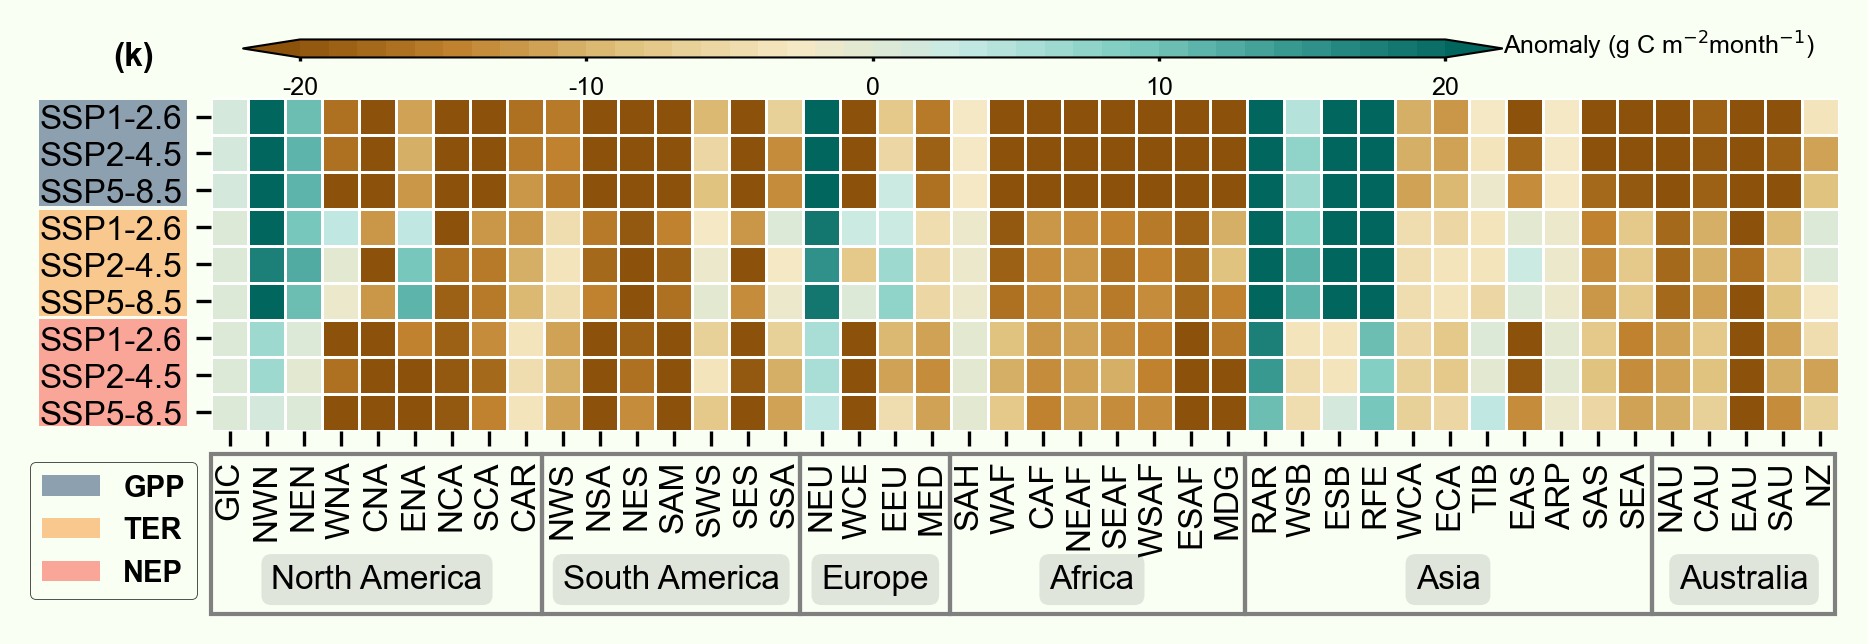

In [225]:
import matplotlib.patches as patches
import seaborn as sb
from matplotlib.colors import BoundaryNorm
mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
fig = plt.figure(figsize=(7,2), dpi=300)
# plot heatmap

ax1 = fig.add_subplot(1, 1, 1)
data_fig.index = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5", "SSP1-2.6", "SSP2-4.5", "SSP5-8.5", "SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
bounds = np.arange(-20, 20.01, 1)
norm1 = mpl.colors.BoundaryNorm(bounds, BRBG_newcmap.N, extend='both')
sb.heatmap(data_fig.astype("float32"),  cmap=BRBG_newcmap, vmin=-20, vmax=20, norm=norm1, square=True,
           linewidth=0.3, cbar=False)
#cbar
ax999 = plt.axes([0.14, 0.84, 0.6, 0.03])
my_norm = BoundaryNorm(bounds, BRBG_newcmap.N, extend="both")
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=my_norm, cmap=BRBG_newcmap), cax=ax999, orientation="horizontal", ticks=[-20, -10, 0, 10, 20], extend="both")
cbar.ax.set_xticklabels([-20, -10, 0, 10, 20], fontsize=6)
cbar.ax.tick_params(size=1)
cbar.outline.set_linewidth(0.5)
ax999.text(
        1.05, 0.2, "Anomaly (g C m$^{-2}$month$^{-1}$)",
        fontsize=6,
        transform = ax999.transAxes
    )


ax1.text(-0.06, 1.1, "(k)", fontsize=8, fontweight="bold", transform=ax1.transAxes)
# NA
rect = patches.Rectangle((0.0, -0.55), 0.203, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# SA
rect = patches.Rectangle((0.203, -0.55), 0.159, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# EU
rect = patches.Rectangle((0.362, -0.55), 0.092, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AF
rect = patches.Rectangle((0.454, -0.55), 0.181, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AS
rect = patches.Rectangle((0.635, -0.55), 0.25, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AU
rect = patches.Rectangle((0.885, -0.55), 0.113, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2, edgecolor="none")
ax1.text(0.037, -0.4, "North America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.216, -0.4, "South America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.375, -0.4, "Europe", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.515, -0.4, "Africa", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.74, -0.4, "Asia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.902, -0.4, "Australia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
rect = patches.Rectangle((-0.106, 0.675), 0.091, 0.32, fill="#23436C", color="#8DA0AF", alpha=1, linewidth=0, zorder=-1, transform=ax1.transAxes)
fig.add_artist(rect)
rect = patches.Rectangle((-0.106, 0.345), 0.091, 0.32, fill="#23436C", color="#F9922C", alpha=0.5, linewidth=0, zorder=-1, transform=ax1.transAxes)
fig.add_artist(rect)
rect = patches.Rectangle((-0.106, 0.015), 0.091, 0.32, fill="#23436C", color="#FA4F3E", alpha=0.5, linewidth=0, zorder=-1, transform=ax1.transAxes)
fig.add_artist(rect)
fig.patch.set_facecolor('#F9FFF3')
ax1.set_facecolor('#F9FFF3')

#legend
legend_elements = [Patch(facecolor="#8DA0AF", edgecolor='None',
                         label='GPP'),
                   Patch(facecolor="#F9C88F", edgecolor='None',
                         label='TER'),
                   Patch(facecolor="#F9A698", edgecolor='None',
                         label='NEP')]
leg = ax1.legend(prop={"size": 7, "weight": "bold"}, fontsize=8, handles=legend_elements, bbox_to_anchor=(0.0, -0.05), edgecolor='k', ncol=1, facecolor="#F9FFF3")
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(0.2)
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_future_eco_2sigma_2080_2099_heatmap.jpg", dpi=300, bbox_inches="tight")

In [240]:
# distribution chart
# GPP data
gpp_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp126\gpp_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")[2].reshape(-1)
ter_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp126\ter_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")[2].reshape(-1)
ter_global =ter_global_2sigma[~np.isnan(ter_global_2sigma)]
gpp_global =gpp_global_2sigma[~np.isnan(gpp_global_2sigma)]
# NEP data
nep_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp126\nep_2sigma_anomalies_cdhw_2080_2099_ssp126.tif")[2].reshape(-1)
nep_global =nep_global_2sigma[~np.isnan(nep_global_2sigma)]

df_global = pd.DataFrame(columns=["Group", "value"])
df_global["value"] = gpp_global
df_global["Group"] = ["GPP"] * gpp_global.shape[0]
df_global_ter = pd.DataFrame(columns=["Group", "value"])
df_global_ter["value"] = ter_global
df_global_ter["Group"] = ["TER"] * ter_global.shape[0]
df_global_nep = pd.DataFrame(columns=["Group", "value"])
df_global_nep["value"] = nep_global
df_global_nep["Group"] = ["NEP"] * nep_global.shape[0]
data_global = pd.concat((df_global, df_global_ter, df_global_nep), axis=0)
data_global["loc"] = ["Global"] * len(data_global)

gpp_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp245\gpp_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")[2].reshape(-1)
ter_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp245\ter_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")[2].reshape(-1)
ter_global =ter_global_2sigma[~np.isnan(ter_global_2sigma)]
gpp_global =gpp_global_2sigma[~np.isnan(gpp_global_2sigma)]
# NEP data
nep_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp245\nep_2sigma_anomalies_cdhw_2080_2099_ssp245.tif")[2].reshape(-1)
nep_global =nep_global_2sigma[~np.isnan(nep_global_2sigma)]

df_global = pd.DataFrame(columns=["Group", "value"])
df_global["value"] = gpp_global
df_global["Group"] = ["GPP"] * gpp_global.shape[0]
df_global_ter = pd.DataFrame(columns=["Group", "value"])
df_global_ter["value"] = ter_global
df_global_ter["Group"] = ["TER"] * ter_global.shape[0]
df_global_nep = pd.DataFrame(columns=["Group", "value"])
df_global_nep["value"] = nep_global
df_global_nep["Group"] = ["NEP"] * nep_global.shape[0]
data_global_ssp245 = pd.concat((df_global, df_global_ter, df_global_nep), axis=0)
data_global_ssp245["loc"] = ["Global"] * len(data_global_ssp245)

gpp_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp585\gpp_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")[2].reshape(-1)
ter_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp585\ter_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")[2].reshape(-1)
ter_global =ter_global_2sigma[~np.isnan(ter_global_2sigma)]
gpp_global =gpp_global_2sigma[~np.isnan(gpp_global_2sigma)]
# NEP data
nep_global_2sigma = get_geotiff_data(r"F:\CMIP6_eco\CDHW\anomalies\anomalies_multimean_resampled_reproj\ssp585\nep_2sigma_anomalies_cdhw_2080_2099_ssp585.tif")[2].reshape(-1)
nep_global =nep_global_2sigma[~np.isnan(nep_global_2sigma)]

df_global = pd.DataFrame(columns=["Group", "value"])
df_global["value"] = gpp_global
df_global["Group"] = ["GPP"] * gpp_global.shape[0]
df_global_ter = pd.DataFrame(columns=["Group", "value"])
df_global_ter["value"] = ter_global
df_global_ter["Group"] = ["TER"] * ter_global.shape[0]
df_global_nep = pd.DataFrame(columns=["Group", "value"])
df_global_nep["value"] = nep_global
df_global_nep["Group"] = ["NEP"] * nep_global.shape[0]
data_global_ssp585 = pd.concat((df_global, df_global_ter, df_global_nep), axis=0)
data_global_ssp585["loc"] = ["Global"] * len(data_global_ssp585)


In [241]:
#rainclouds
import ptitprince as pt
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

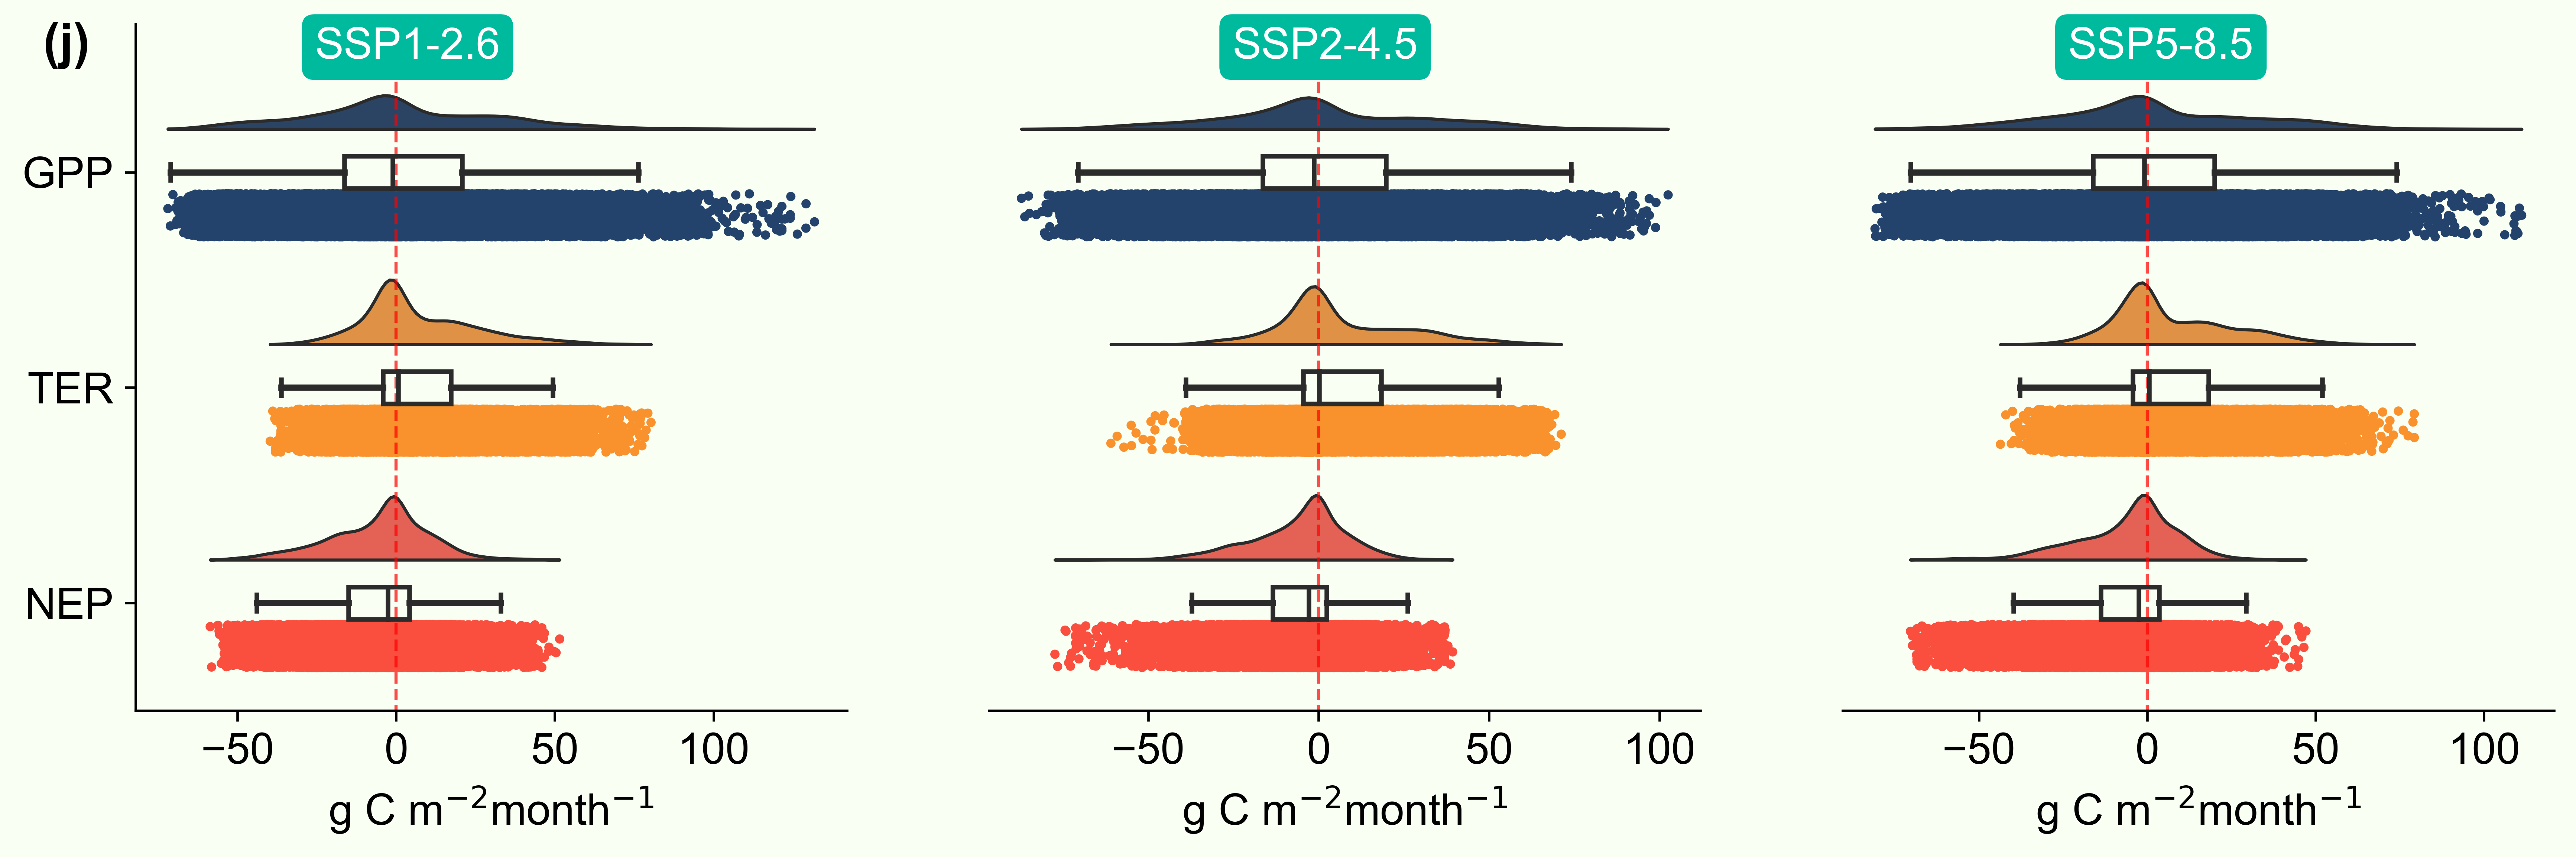

In [245]:
mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":14})
fig = plt.figure(figsize=(14,4), dpi=600)
ax = fig.add_subplot(1, 3, 1)
dx="Group"; dy="value"; ort="h"; pal=["#23436C", "#F9922C" ,"#FA4F3E"]; sigma=.2
ax=pt.RainCloud(x=dx, y=dy, data=data_global, palette=pal, bw=sigma,
                 width_viol=.6, ax=ax, orient=ort, move=.2, box_showfliers= False, box_whis=1.5)
ax.vlines(x=0, ymin=-100, ymax=100, color='r', linewidth=1, linestyle="--", alpha=0.7)
ax.set_xlabel("g C m$^{-2}$month$^{-1}$")
ax.set_ylabel("")

ax2 = fig.add_subplot(1, 3, 2)
dx="Group"; dy="value"; ort="h"; pal=["#23436C", "#F9922C" ,"#FA4F3E"]; sigma=.2
ax2=pt.RainCloud(x=dx, y=dy, data=data_global_ssp245, palette=pal, bw=sigma,
                 width_viol=.6, ax=ax2, orient=ort, move=.2, box_showfliers= False, box_whis=1.5)
ax2.vlines(x=0, ymin=-100, ymax=100, color='r', linewidth=1, linestyle="--", alpha=0.7)
ax2.set_xlabel("g C m$^{-2}$month$^{-1}$")
ax2.set_ylabel("")

ax3 = fig.add_subplot(1, 3, 3)
dx="Group"; dy="value"; ort="h"; pal=["#23436C", "#F9922C" ,"#FA4F3E"]; sigma=.2
ax3=pt.RainCloud(x=dx, y=dy, data=data_global_ssp585, palette=pal, bw=sigma,
                 width_viol=.6, ax=ax3, orient=ort, move=.2, box_showfliers= False, box_whis=1.5)
ax3.vlines(x=0, ymin=-100, ymax=100, color='r', linewidth=1, linestyle="--", alpha=0.7)
ax3.set_xlabel("g C m$^{-2}$month$^{-1}$")
ax3.set_ylabel("")

ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False) 
ax2.spines['top'].set_visible(False)  
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False) 
ax3.spines['top'].set_visible(False)  
ax3.spines['right'].set_visible(False)
ax2.set_yticks([])
ax3.set_yticks([])
fig.patch.set_facecolor('#F9FFF3')
ax.set_facecolor('#F9FFF3')
ax2.set_facecolor('#F9FFF3')
ax3.set_facecolor('#F9FFF3')
props = dict(boxstyle='round', facecolor='#00BA9E', alpha=1, edgecolor="none")
ax.text(
        0.252, 0.95, "SSP1-2.6",
        color="white",
        fontsize=14,
        transform = ax.transAxes,
        bbox=props
    
    )
ax2.text(
        0.342, 0.95, "SSP2-4.5",
        color="white",
        fontsize=14,
        transform = ax2.transAxes,
        bbox=props
    
    )
ax3.text(
        0.317, 0.95, "SSP5-8.5",
        color="white",
        fontsize=14,
        transform = ax3.transAxes,
        bbox=props
    
    )
ax.text(-0.13, 0.95, "(j)", fontsize=16, fontweight="bold", transform=ax.transAxes)
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CMIP6_future_eco_2sigma_2080_2099_global.jpg", dpi=600, bbox_inches="tight")